# Assignment 2
## Part 2: Scale-Space Blob Construction   
Mohammad Rashiqul Alam  
malam25@illinois.edu  

In [3]:
# Modules
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image
from scipy.ndimage import gaussian_filter, gaussian_laplace
from skimage import filters, feature, util, color
from skimage.transform import resize

## Image Pre-Processing

### Import All ALigned Images
Import low-resolution images from ~/Gen/a2/lowres_rgb/preprocessed  
Import high-resolution images from ~/Gen/a2/hires_rgb/preprocessed

**Notebook assumes the output has been generated froma alam_rashiqul_a2_p1.pynb

In [4]:
# Import aligned images to notebook
def import_aligned_images(path, ext='jpg'):
    """
    Function to import aligned images from a specified directory, 
    only those ending with *_aligned.jpg.
    Args:
    - path: str, path to the directory containing images
    - ext: str, file extension of the images to import (default: 'jpg')
    Returns:
    - images: list of numpy arrays (each image)
    """
    images = []
    for file in os.listdir(path):
        if file.endswith(f"_aligned.{ext}"):
            img = Image.open(os.path.join(path, file))
            images.append(np.array(img))
    return images

# Plot aligned images
def plot_aligned_images(images, filenames=None, use_gray=False):
    """
    Function to plot all aligned images from the dataset.
    Args:
        images: list of numpy arrays (each image)
        filenames: list of filenames corresponding to images (optional)
        use_gray: bool, if True use grayscale colormap
    Returns:
        None
    """
    n = len(images)
    plt.figure(figsize=(2.5 * n, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        if use_gray:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.axis("off")
        if filenames:
            name = filenames[i].replace('_aligned.jpg', '').replace('_aligned.jpeg', '').replace('_aligned.png', '')
            ax.set_title(name, fontsize=10)
    plt.show()

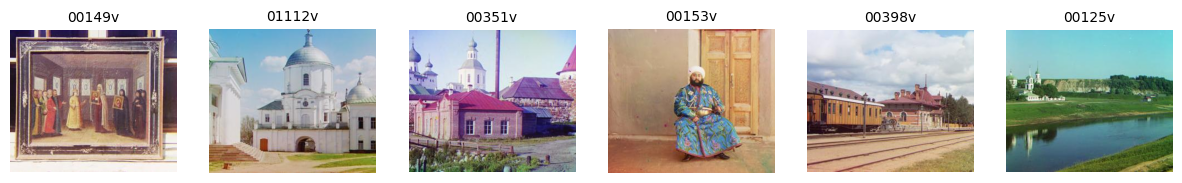

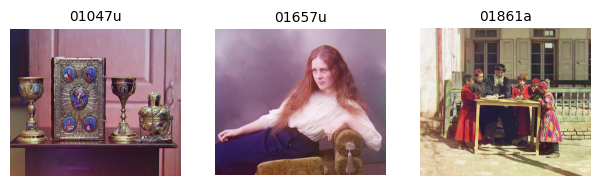

In [5]:
# Get the directory one level above the notebook location
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
lowres_preproc_dir = os.path.join(parent_dir, "Gen", "a2", "lowres_rgb", "preprocessed")
highres_preproc_dir = os.path.join(parent_dir, "Gen", "a2", "hires_rgb", "preprocessed")

# Import low-res images
low_res_images = import_aligned_images(lowres_preproc_dir, ext='jpg')
# Get filenames for low-res images
low_res_filenames = [f for f in os.listdir(lowres_preproc_dir) if f.endswith("_aligned.jpg")]
# Import high-res images
high_res_images = import_aligned_images(highres_preproc_dir, ext='jpg')
# Get filenames for high-res images
high_res_filenames = [f for f in os.listdir(highres_preproc_dir) if f.endswith("_aligned.jpg")]

# Plot images
plot_aligned_images(low_res_images, low_res_filenames, use_gray=False)
plot_aligned_images(high_res_images, high_res_filenames, use_gray=False)

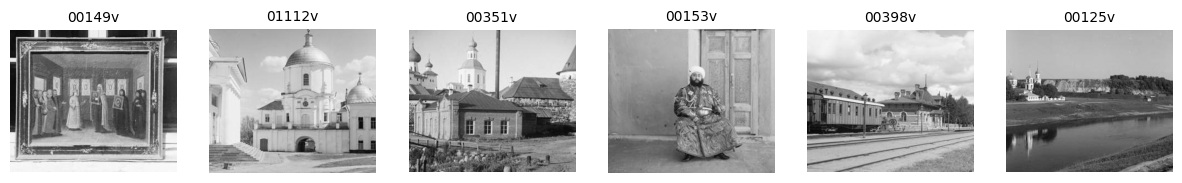

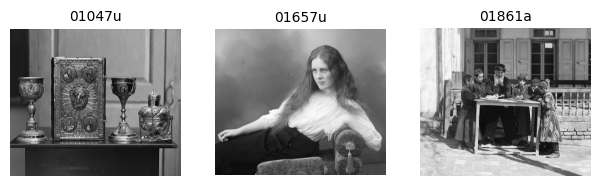

In [6]:
# Convert images to grayscale and rescale intensities to [0, 1]
low_res_gray = [np.array(Image.fromarray(img).convert('L')) / 255.0 for img in low_res_images]
high_res_gray = [np.array(Image.fromarray(img).convert('L')) / 255.0 for img in high_res_images]

# Plot gray-scale images
plot_aligned_images(low_res_gray, low_res_filenames, use_gray=True)
plot_aligned_images(high_res_gray, high_res_filenames, use_gray=True)

### Choice of Images for Part 2: Scale-Space Blob Construction

Selected four aligned images for this part of the assignment:
1. **00125v_aligned.jpg (Church by river)**  
   - Contains both natural features (trees, cliffs, river) and man-made structures (church buildings).  
   - Provides a mix of sharp corners and smoother regions, useful for testing corner detection and blob scale behavior.
2. **00351v_aligned.jpg (Brick house with domes)**  
   - Rich in architectural detail with windows, rooftops, and domes.  
   - Good distribution of corners and circular blob-like features at different scales.
3. **00398v_aligned.jpg (Train station with train cars)**  
   - Strong geometric patterns from train cars, station buildings, and tracks.  
   - Tests whether the method correctly preserves scale/orientation across repeating man-made structures.
4. **01047u_aligned.jpg (Chalices and book)**  
   - Objects with fine texture and small-scale blob-like details (ornamental designs, circular cups).  
   - Complements the larger-scale features in the other images with smaller, high-detail regions.

Selected image keys: dict_keys(['00125v', '00351v', '00398v', '01047u'])


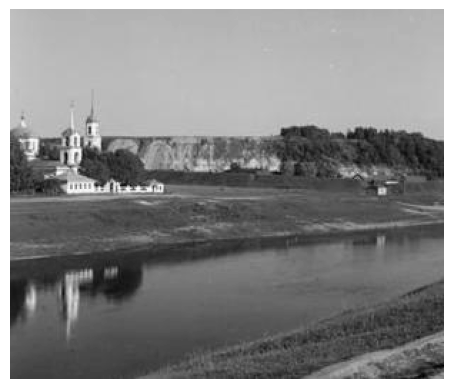

00125v


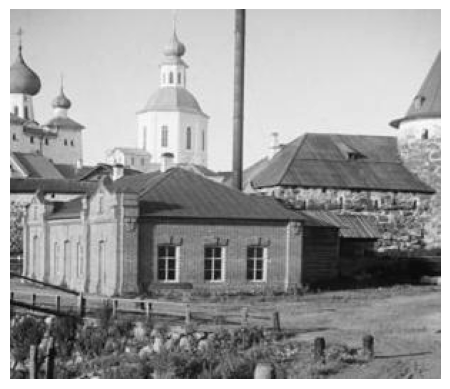

00351v


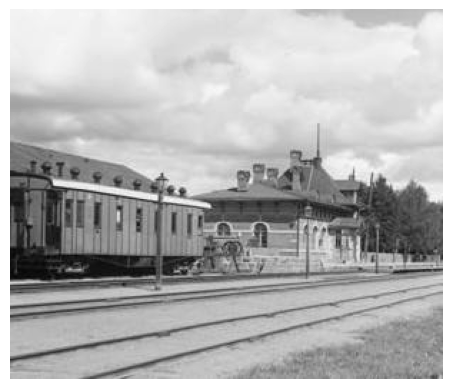

00398v


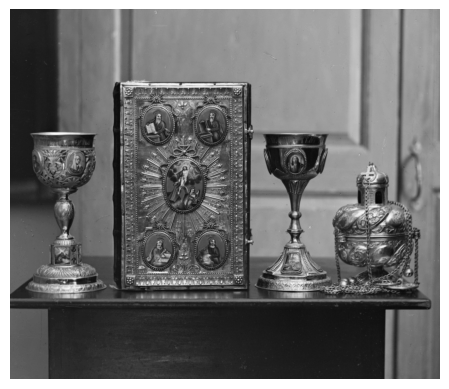

01047u


In [7]:
selected_names = [
    "00125v_aligned.jpg",
    "00351v_aligned.jpg",
    "00398v_aligned.jpg",
    "01047u_aligned.jpg"
]

# Build the dictionary
selected_images_dict = {}

# Add low-res and high-res images to the dictionary
for name in selected_names:
    key = name.replace('_aligned.jpg', '')
    # Try to find in high-res first
    if name in high_res_filenames:
        idx = high_res_filenames.index(name)
        selected_images_dict[key] = high_res_gray[idx]
    # If not found, try low-res
    elif name in low_res_filenames:
        idx = low_res_filenames.index(name)
        selected_images_dict[key] = low_res_gray[idx]
    else:
        print(f"Warning: {name} not found in either low-res or high-res images.")

# Print the keys of the selected images dictionary
print("Selected image keys:", selected_images_dict.keys())

# Plot the images
for name, image in selected_images_dict.items():
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()
    print(f"{name}")

## Build a Harris-Corner Detector
### Harris Corner Detector (based on textbook, Section 8.2.1)

Corners are a special type of **interest point**:  
- In a flat region → gradients are small in every direction.  
- Along an edge → there is a strong gradient, but only in **one** direction.  
- At a corner → there are strong gradients in **two different directions**, so the local patch cannot be slid around without changing the image content.

The Harris detector formalizes this by looking at the **second moment matrix** (also called the structure tensor) in a small neighborhood:

$$
H = \sum_{\text{window}}
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
$$
  
where $I_x, I_y$ are image gradients.

**Steps:**
1. **Compute image gradients**  
   Use derivative filters (e.g., Sobel or derivative of Gaussian) to obtain $I_x$ and $I_y$.

2. **Form the structure tensor**  
   Build the matrix $H$ from $I_x^2$, $I_y^2$, $I_x I_y$.  
   Smooth these terms with a Gaussian window so that the tensor reflects a local neighborhood rather than a single pixel.

3. **Analyze eigenvalues of \(H\)**  
   - If both eigenvalues are small → flat region.  
   - If one eigenvalue is large, one small → edge.  
   - If both are large → corner. :contentReference[oaicite:0]{index=0}

4. **Corner response function**  
   Instead of explicitly computing eigenvalues, Harris proposed a simple test:  
   $$
   R = \det(H) - k \cdot (\text{trace}(H))^2
   $$
   where $k$ is a constant (typically $\sim 0.04$–$0.06$).  
   Large positive values of $R$ indicate likely corners.

5. **Find local maxima**  
   Search the response map $R$ for local peaks above a threshold. 
   These become the final **corner points**.

**Key properties:**
- Harris corners are **covariant to translation and rotation** (the same points appear when the image shifts or rotates).
- They are sensitive to **contrast** (stronger response at high-contrast corners).
- They provide a compact set of distinctive, localizable points for further processing.


In [8]:
# Default harris corner detection configurations
harris_configs = dict(
    sigma_grad=1.0,       # Gaussian smoothing scale for gradient estimation
    sigma_window=1.5,     # Gaussian window scale for structure tensor
    k=0.04,               # Harris detector free parameter (typically 0.04–0.06)
    min_distance=6,       # Minimum separation between detected corners (pixels)
    threshold_rel=0.005,  # Relative threshold for peak selection (fraction of max R)
    max_peaks=750         # Maximum number of corners to return
)

In [9]:
def compute_image_gradients(image, *, sigma_grad=1.0):
    """
    Estimate image gradients grad_x, grad_y.
    Args:
    - image: 2D numpy array (grayscale image)
    - sigma_grad: float, standard deviation for Gaussian smoothing
    Returns:
    - grad_x: 2D numpy array, gradient in x direction
    - grad_y: 2D numpy array, gradient in y direction
    """
    smoothed_image = filters.gaussian(image, sigma=sigma_grad, preserve_range=True, mode='reflect')
    grad_x = filters.sobel_h(smoothed_image)   # ∂I/∂x
    grad_y = filters.sobel_v(smoothed_image)   # ∂I/∂y
    return grad_x, grad_y

def compute_structure_tensor(grad_x, grad_y, *, sigma_window=1.5):
    """
    Build and smooth second-moment (structure) tensor entries in a local window.
      A = Gsigma * (grad_x^2),  B = Gsigma * (grad_y^2),  C = Gsigma * (grad_x*grad_y)
      where Gsigma is a Gaussian with sigma_window.
    Args:
    - grad_x: 2D numpy array, gradient in x direction
    - grad_y: 2D numpy array, gradient in y direction
    - sigma_window: float, standard deviation for Gaussian smoothing of tensor entries
    Returns:
    - tensor_xx: 2D numpy array, smoothed grad_x^2
    - tensor_yy: 2D numpy array, smoothed grad_y^2
    - tensor_xy: 2D numpy array, smoothed grad_x * grad_y
    """
    grad_xx = grad_x * grad_x
    grad_yy = grad_y * grad_y
    grad_xy = grad_x * grad_y

    tensor_xx = filters.gaussian(grad_xx, sigma=sigma_window, preserve_range=True, mode='reflect')
    tensor_yy = filters.gaussian(grad_yy, sigma=sigma_window, preserve_range=True, mode='reflect')
    tensor_xy = filters.gaussian(grad_xy, sigma=sigma_window, preserve_range=True, mode='reflect')
    return tensor_xx, tensor_yy, tensor_xy

def compute_harris_response(tensor_xx, tensor_yy, tensor_xy, *, k=0.04):
    """
    Harris response:
      det(H) - k * (trace(H))^2
      with H = [[tensor_xx, tensor_xy], [tensor_xy, tensor_yy]]
    Large positive R => likely corner (both eigenvalues large).
    Args:
    - tensor_xx: 2D numpy array, smoothed grad_x^2
    - tensor_yy: 2D numpy array, smoothed grad_y^2
    - tensor_xy: 2D numpy array, smoothed grad_x * grad_y
    - k: float, Harris detector free parameter (typically 0.04 - 0.06)
    Returns:
    - response: 2D numpy array, Harris corner response map
    """
    det_H   = tensor_xx * tensor_yy - tensor_xy * tensor_xy
    trace_H = tensor_xx + tensor_yy
    response = det_H - k * (trace_H ** 2)
    return response

def select_harris_corners(response, *, min_distance=6, threshold_rel=0.01, max_peaks=500):
    """
    Local maxima in response above relative threshold; enforce spatial separation.
    Returns Nx2 coordinates as (row=y, col=x).
    Args:
    - response: 2D numpy array, Harris corner response map
    - min_distance: int, minimum number of pixels separating peaks
    - threshold_rel: float, relative threshold for peak selection (fraction of max response)
    - max_peaks: int, maximum number of peaks to return
    Returns:
    - corner_coords: Nx2 numpy array of (row, col) coordinates of detected corners
    """
    corner_coords = feature.peak_local_max(
        response,
        min_distance=min_distance,
        threshold_rel=threshold_rel,
        num_peaks=max_peaks
    )
    return corner_coords

In [10]:
# Harris corner detection function
def harris_corner_detector(
    image, 
    sigma_grad=1.0, 
    sigma_window=1.5, 
    k=0.04, 
    min_distance=6, 
    threshold_rel=0.01, 
    max_peaks=500
):
    """
    Function to perform Harris corner detection on a grayscale image.
    Args:
        image: 2D numpy array, input grayscale image
        sigma_grad: float, Gaussian smoothing scale for gradient estimation
        sigma_window: float, Gaussian window scale for structure tensor
        k: float, Harris detector free parameter (typically 0.04–0.06)
        min_distance: int, minimum separation between detected corners (pixels)
        threshold_rel: float, relative threshold for peak selection (fraction of max R)
        max_peaks: int, maximum number of corners to return
    Returns:
        harris_response: 2D numpy array, Harris response image
        corner_coords: Nx2 numpy array, coordinates of detected corners (row, col)
    """
    # Step 1: Compute image gradients
    grad_x, grad_y = compute_image_gradients(image, sigma_grad=sigma_grad)
    # Step 2: Compute structure tensor components
    tensor_xx, tensor_yy, tensor_xy = compute_structure_tensor(grad_x, grad_y, sigma_window=sigma_window)
    # Step 3: Compute Harris response
    harris_response = compute_harris_response(tensor_xx, tensor_yy, tensor_xy, k=k)
    # Step 4: Select corners from the response
    corner_coords = select_harris_corners(
        harris_response, 
        min_distance=min_distance, 
        threshold_rel=threshold_rel, 
        max_peaks=max_peaks
    )
    # Return response and coordinates
    return harris_response, corner_coords

In [11]:
def plot_corner_overlay(image, corner_coords, title="Harris corners"):
    """
    Overlay detected corners on the image.
    Args:
        image: 2D numpy array, grayscale image
        corner_coords: Nx2 numpy array, coordinates of detected corners (row, col)
        title: str, plot title
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    if len(corner_coords) > 0:
        ax.plot(corner_coords[:, 1], corner_coords[:, 0], 'r.', markersize=3)
    ax.set_title(f"{title} — {len(corner_coords)} corners")
    ax.axis('off')
    plt.show()

In [12]:
# Entry function for Harris corner detection
def run_harris_on_selected_images(selected_images_dict, show=True):
    """
    Function to run harris corner detection on selected images.
    Args:
        selected_images_dict: dictionary containing selected images
        show: if True display the results
    Returns:
        results: dictionary with Harris corner detection results
    """
    results = {}
    for name, image in selected_images_dict.items():
        harris_response, corner_coords = harris_corner_detector(image, **harris_configs)
        if show:
            plot_corner_overlay(image, corner_coords, title=f"{name}")
        results[name] = {'response': harris_response, 'coords': corner_coords}
    return results

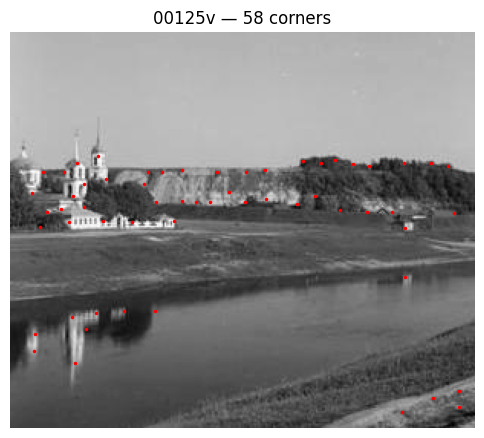

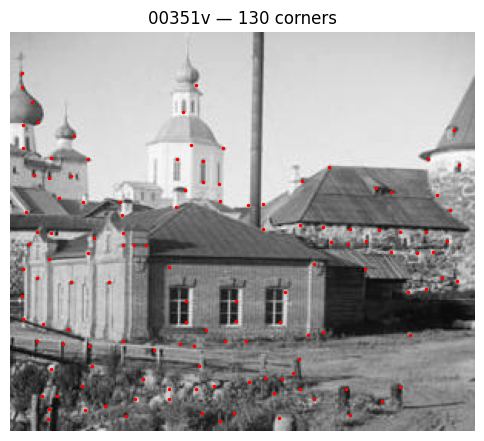

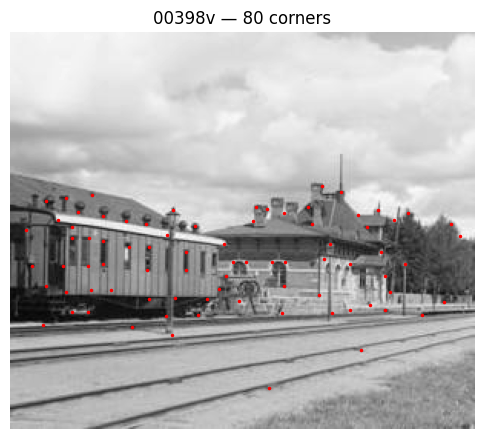

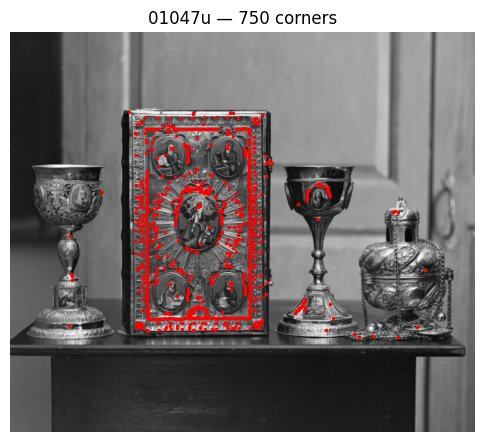

00125v corners: 58
00351v corners: 130
00398v corners: 80
01047u corners: 750


In [13]:
# Run Harris corner detection on selected images
harris_results = run_harris_on_selected_images(selected_images_dict, show=True)

# Print number of corners detected in each image
for k, v in harris_results.items():
    print(k, "corners:", len(v['coords']))

### Scale-Space Blob Detection (based on textbook, Section 8.2.2)
**Scale Pyramid:**  
Construct a set of scales:
$$
\sigma_i = \sigma_0 \cdot k^i \quad (i = 0, 1, \ldots, L-1)
$$
Typical values:  
$$
\sigma_0 \approx 2, \quad L = 10\text{–}15
$$

**Scale-Normalized LoG:**  
For each scale \(\sigma\), compute:
$$
R_\sigma = \sigma^2 \cdot \nabla^2 G_\sigma * I
$$
using `scipy.ndimage.gaussian_laplace`. The $\sigma^2$ factor ensures fair comparison across scales.

**Response Sampling at Corners:**  
At each Harris corner coordinate, record the LoG response for all scales in the pyramid.

**Characteristic Scale Selection:**  
For each corner, pick the scale that maximizes the absolute response $|R_\sigma|$..

**Sub-Scale Refinement:**  
Apply a quadratic fit in $\log \sigma$ around the discrete maximum to interpolate a more precise characteristic scale.

### Scale Selection via Pyramid LoG

- Build a geometric scale set:  
  $$
  \sigma_\ell = \sigma_0 \, k^\ell, \quad \ell = 0 \dots L-1
  $$

- For each level $\ell$:
    1. Downsample the image by  
       $$
       \text{factor} = \frac{\sigma_0}{\sigma_\ell}
       $$
    2. Apply a fixed-scale LoG at $\sigma_0$ on the downsampled image.
    3. Multiply by $\sigma_\ell^2$ for scale normalization.
    4. Upsample the response back to the original size.

- At every Harris corner, sample the responses across levels and choose the $\sigma_\ell$ that maximizes $|R_\sigma|$.

- Refine the scale by a quadratic fit in $\log \sigma$ around the peak to obtain a sub-level estimate.

In [14]:
def pyramid_log_responses(image, sigma0=2.0, scale_factor=1.25, num_levels=12):
    """
    Build a stack of scale-normalized LoG responses for a geometric scale pyramid.

    For each scale in the pyramid:
      - Downsample the image by (sigma0 / scale)
      - Apply gaussian_laplace at *fixed* sigma0 on the downsampled image
      - Multiply by scale^2 for scale normalization
      - Upsample response back to the original image size

    Args:
      image: 2D numpy array (grayscale, values in [0,1])
      sigma0: float, base scale for LoG filtering
      scale_factor: float, geometric step between scales
      num_levels: int, number of scales in the pyramid

    Returns:
      response_stack: np.ndarray of shape (num_levels, H, W), each slice is one scale's response
      scales: list of scale values used
    """
    H, W = image.shape
    scales = [sigma0 * (scale_factor ** level) for level in range(num_levels)]  # List of scales
    response_stack = np.zeros((num_levels, H, W), dtype=np.float64)  # Stack to hold responses

    for level, scale in enumerate(scales):
        # Compute downsampling factor for this scale
        downsample_factor = sigma0 / scale
        # Clamp minimum size to 8x8 to avoid too small images
        h = max(8, int(round(H * downsample_factor)))
        w = max(8, int(round(W * downsample_factor)))

        # 1) Downsample image to current scale
        image_small = resize(image, (h, w), order=1, anti_aliasing=True, preserve_range=True)

        # 2) Apply LoG at fixed sigma0 on the downsampled image
        log_response = gaussian_laplace(image_small, sigma=sigma0, mode='reflect')

        # 3) Scale-normalize the response for fair comparison across scales
        log_response *= (scale ** 2)

        # 4) Upsample response back to original resolution (no anti-aliasing needed)
        response_resized = resize(log_response, (H, W), order=1, anti_aliasing=False, preserve_range=True)
        response_stack[level] = response_resized  # Store in stack

    return response_stack, scales

def parabolic_refine_log_scale(scales, abs_values, peak_idx):
    """
    One-dimensional quadratic fit in log(scale) around the discrete maximum.
    Inputs:
      - scales: list/array of scales (len >= 3)
      - abs_values: |response| at those scales (same length)
      - peak_idx: index of discrete maximum in abs_values
    Returns:
      - refined_scale: sub-level estimate clamped to neighbors if ill-conditioned
    """
    if peak_idx == 0 or peak_idx == len(scales) - 1:
        return float(scales[peak_idx])  # cannot refine at ends

    # Fit a parabola y = a x^2 + b x + c through three points in x = log(scale)
    xs = np.log(np.asarray(scales[peak_idx-1:peak_idx+2], dtype=float))  # log-scales
    ys = np.asarray(abs_values[peak_idx-1:peak_idx+2], dtype=float)      # abs responses

    A = np.vstack([xs**2, xs, np.ones_like(xs)]).T  # Design matrix for quadratic fit
    a, b, c = np.linalg.lstsq(A, ys, rcond=None)[0] # Solve for parabola coefficients

    if a == 0:
        x_peak = xs[1]  # middle (no curvature)
    else:
        x_peak = -b / (2 * a)  # vertex of parabola

    # Clamp refined log-scale to the local bracket
    x_peak = float(np.clip(x_peak, xs[0], xs[-1]))
    return float(np.exp(x_peak))  # convert back from log-scale to scale

In [15]:
def detect_blob_scales(
    image,
    corner_coords,
    sigma0=2.0,
    scale_factor=1.25,
    num_levels=12,
    return_full_matrix=False
):
    """
    For each Harris corner, select a characteristic scale using scale-normalized LoG.

    Steps:
      1) Build geometric scale set: scale_i = sigma0 * scale_factor^i.
      2) For each scale, compute response = scale^2 * LoG(image, scale).
      3) For each corner, collect responses across scales and pick the scale giving
         max |response| (corner-strength at that location in scale-space).
      4) Refine scale via a small parabolic fit in log(scale) around the discrete maximum.

    Args:
      image : 2D float array in [0,1] (grayscale)
      corner_coords : (N,2) int/float array of (row, col) from Harris
      sigma0, scale_factor, num_levels : scale set parameters
      return_full_matrix : if True, also return the full response matrix (N x L)

    Returns:
      best_scales      : (N,) array, refined scale per corner
      best_responses   : (N,) array, signed LoG value at the discrete best level (for diagnostics)
      scales           : list of scales used
      response_matrix  : (optional) (N,L) matrix of raw (signed) responses per point/scale
    """
    # Build the stack of LoG responses for all scales
    response_stack, scales = pyramid_log_responses(
        image, sigma0=sigma0, scale_factor=scale_factor, num_levels=num_levels
    )  # response_stack shape: (num_levels, H, W)

    num_points = len(corner_coords)
    num_scales = len(scales)

    # Sample responses at corner points for all scales
    rows = corner_coords[:, 0].astype(int)
    cols = corner_coords[:, 1].astype(int)
    response_matrix = response_stack[:, rows, cols].T  # shape (N, L)

    # For each corner, find the scale with the maximum absolute response
    best_scales = np.empty(num_points, dtype=np.float64)
    best_responses = np.empty(num_points, dtype=np.float64)

    # Pick best scale per point + parabolic refinement in log-scale
    abs_response_matrix = np.abs(response_matrix)
    max_idx_per_point = np.argmax(abs_response_matrix, axis=1)  # Index of best scale per point

    for i in range(num_points):
        j = int(max_idx_per_point[i])
        best_responses[i] = response_matrix[i, j]  # Signed LoG value at best scale
        best_scales[i] = parabolic_refine_log_scale(scales, abs_response_matrix[i], j)  # Refined scale

    if return_full_matrix:
        return best_scales, best_responses, scales, response_matrix
    else:
        return best_scales, best_responses, scales

In [16]:
# --- Step 1: Compute and store best scales for each image ---
blob_scale_results = {}

for name, image in selected_images_dict.items():
    coords = harris_results[name]['coords']
    best_scales, best_responses, scales = detect_blob_scales(
        image,
        coords,
        sigma0=2.0,
        scale_factor=1.2,
        num_levels=10,
        return_full_matrix=False
    )
    blob_scale_results[name] = {
        'coords': coords,
        'best_scales': best_scales,
        'best_responses': best_responses,
        'scales': scales
    }

In [20]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

Showing circles for 00125v...


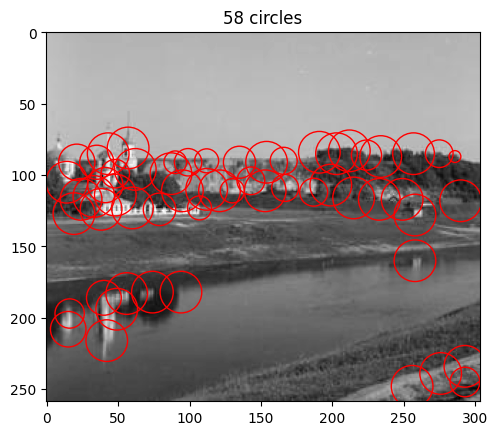

Showing circles for 00351v...


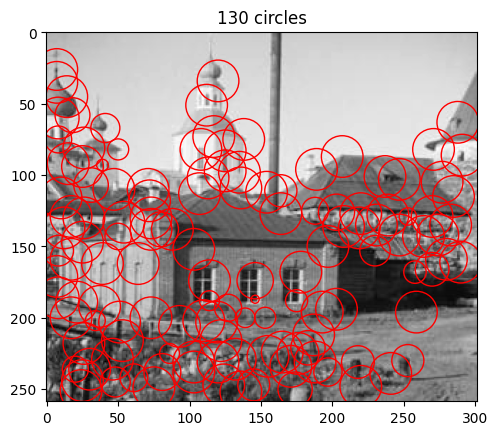

Showing circles for 00398v...


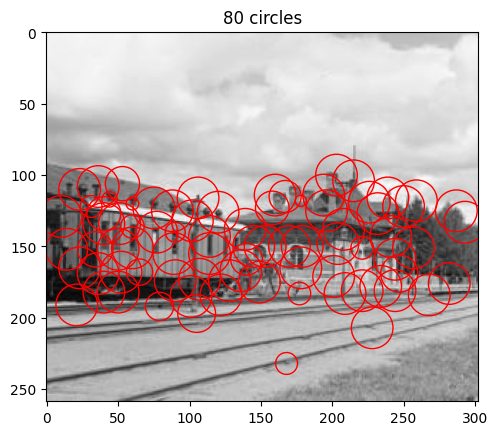

Showing circles for 01047u...


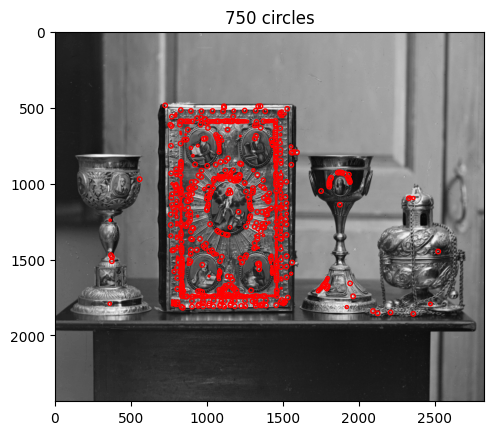

In [21]:
# Plot blob circles for each image using precomputed scales
for name, image in selected_images_dict.items():
    result = blob_scale_results[name]
    print(f"Showing circles for {name}...")
    # Call the plotting function with precomputed scales and responses
    show_all_circles(
        image=image,
        cx=result['coords'][:, 1],
        cy=result['coords'][:, 0],
        rad=np.sqrt(2) * result['best_scales']
    )